In [1]:
!pip install einops torch maze-dataset --q

In [2]:
from maze_dataset import MazeDataset, MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators

cfg: MazeDatasetConfig = MazeDatasetConfig(
	name="test", # name is only for you to keep track of things
	grid_n=16, # number of rows/columns in the lattice
	n_mazes=50000, # number of mazes to generate
	maze_ctor=LatticeMazeGenerators.gen_dfs, # algorithm to generate the maze
    maze_ctor_kwargs=dict(do_forks=False), # additional parameters to pass to the maze generation algorithm
)
dataset: MazeDataset = MazeDataset.from_config(cfg)

## Diffusion

### VAE Training

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot

In [4]:
import importlib
import encoder
import decoder
importlib.reload(encoder)
importlib.reload(decoder)
from encoder import VAE_Encoder
from decoder import VAE_Decoder

In [5]:
# Hyperparameters
BATCH_SIZE = 512
LEARNING_RATE = 1e-4
EPOCHS = 150
LATENT_CHANNELS = 4


# 10,000 imgs, with lr = 1e-4 and 100 epcs gives loss = 110 which is good

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


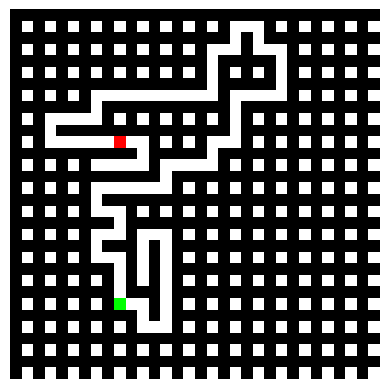

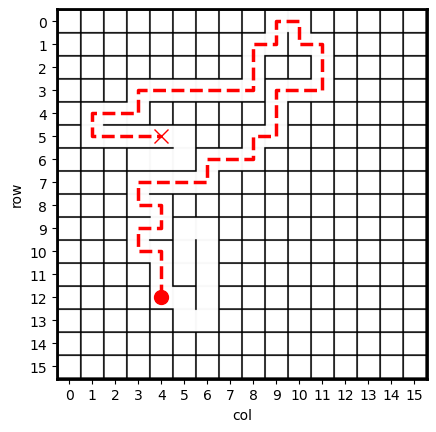

In [6]:
# Preprocessing Transformations
def preprocess_image(image, target_size=32):
    image = np.array(image)
    
    # scale_factor = target_size // image.shape[0] 

    # image = np.kron(image, np.ones((scale_factor, scale_factor, 1))) 

    image = image.astype(np.float32) / 127.5 - 1
    image = torch.tensor(image).permute(2, 0, 1)

    return image

def remove_sol(dataset):
    new_dataset = []
    for i in dataset:
        img = i.as_pixels()
        mask = np.all(img == [0, 0, 255], axis=-1)
        img[mask] = [255, 255, 255]
        img = img[:-1, :-1]
        new_dataset.append(preprocess_image(img))
        
        # new_dataset.append(img)
    return new_dataset

new_dataset = remove_sol(dataset)
plt.imshow(new_dataset[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

MazePlot(dataset[0]).plot()

class MazeTensorDataset(Dataset):
    def __init__(self, images):
        self.images = images
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]

# Create DataLoader
dataset = MazeTensorDataset(new_dataset)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Epoch [1/150], Train Loss: 959.1347
Epoch [2/150], Train Loss: 378.9911
Epoch [3/150], Train Loss: 346.7213
Epoch [4/150], Train Loss: 324.4100
Epoch [5/150], Train Loss: 301.4711
Epoch [6/150], Train Loss: 280.2536
Epoch [7/150], Train Loss: 260.4551
Epoch [8/150], Train Loss: 241.8994
Epoch [9/150], Train Loss: 222.7892
Epoch [10/150], Train Loss: 207.4932
Epoch [11/150], Train Loss: 194.0418
Epoch [12/150], Train Loss: 179.9399
Epoch [13/150], Train Loss: 170.9825
Epoch [14/150], Train Loss: 161.2164
Epoch [15/150], Train Loss: 154.3506
Epoch [16/150], Train Loss: 150.0224
Epoch [17/150], Train Loss: 143.4177
Epoch [18/150], Train Loss: 139.6952
Epoch [19/150], Train Loss: 137.8576
Epoch [20/150], Train Loss: 133.4169
Epoch [21/150], Train Loss: 130.8643
Epoch [22/150], Train Loss: 129.4819
Epoch [23/150], Train Loss: 126.7307
Epoch [24/150], Train Loss: 125.4766
Epoch [25/150], Train Loss: 123.7151
Epoch [26/150], Train Loss: 122.4759
Epoch [27/150], Train Loss: 120.5292
Epoch [28/

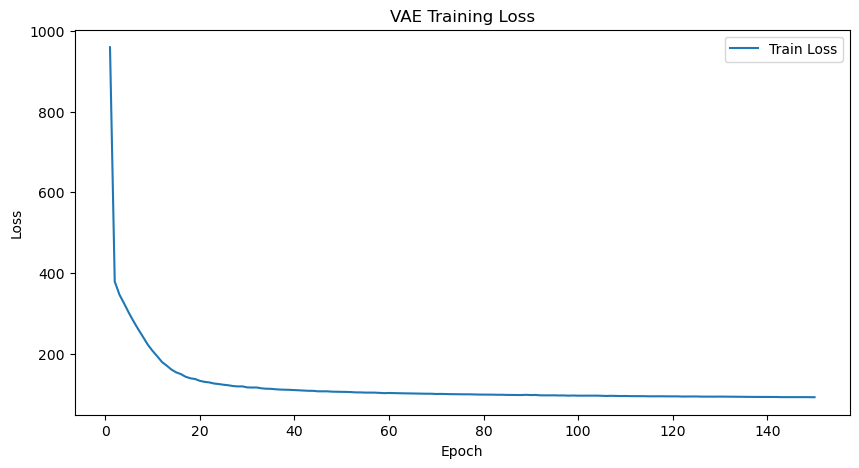

In [7]:
# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = VAE_Encoder().to(device)
decoder = VAE_Decoder().to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE)

def vae_loss(x, x_hat, mean, log_var):
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    
    kl_loss = 0.5 * (mean.pow(2) + log_var.exp() - log_var - 1).sum(dim=(1, 2, 3)).mean()
    
    return recon_loss + kl_loss

train_losses = []
for epoch in range(EPOCHS):
    encoder.train()
    decoder.train()
    train_loss = 0.0
    
    for batch_idx, x in enumerate(dataloader):
        x = x.to(device)
        batch_size = x.size(0)
        
        noise = torch.randn(batch_size, LATENT_CHANNELS, 8, 8).to(device)
        
        mean, log_var, z = encoder(x, noise)
        x_hat = decoder(z)
        
        loss = vae_loss(x, x_hat, mean, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_size
        
    train_loss = train_loss / len(dataloader.dataset)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0893824..1.0908107].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0962095..1.0738676].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0880662..1.0712467].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid 

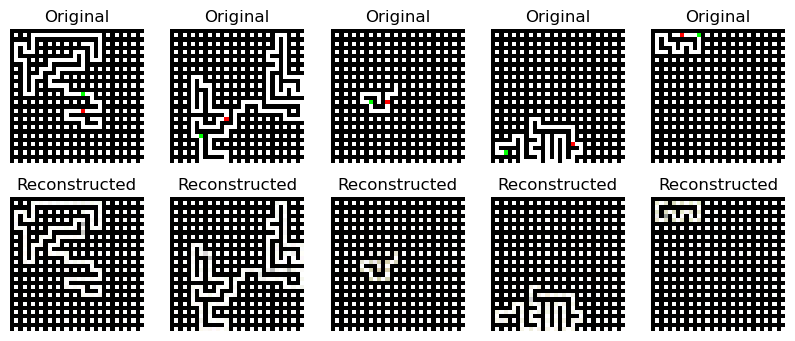

In [8]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        idx = np.random.randint(len(dataset))
        img = dataset[idx].unsqueeze(0).to(device)
        noise = torch.randn(1, LATENT_CHANNELS, 8, 8).to(device)
        
        _, _, z = encoder(img, noise)
        reconstructed = decoder(z).cpu().squeeze(0)
        
        axes[0, i].imshow(img.cpu().squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        axes[1, i].imshow(reconstructed.permute(1, 2, 0).numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0393461..1.055222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.1920929e-07..1.9047449].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0906255..1.0949339].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.66893e-06..1.9671848].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input dat

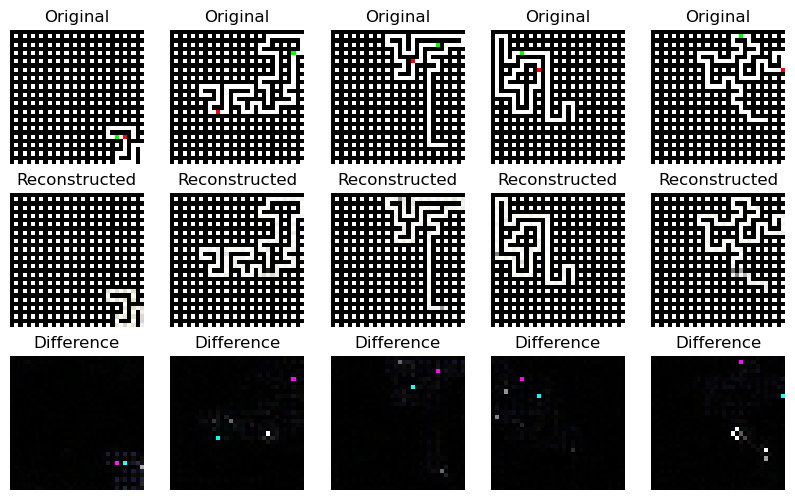

In [9]:
with torch.no_grad():
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    for i in range(5):
        idx = np.random.randint(len(dataset))
        img = dataset[idx].unsqueeze(0).to(device)
        noise = torch.randn(1, LATENT_CHANNELS, 8, 8).to(device)
        
        _, _, z = encoder(img, noise)
        reconstructed = decoder(z).cpu().squeeze(0)
        
        difference = torch.abs(img.cpu().squeeze(0) - reconstructed)
        
        axes[0, i].imshow(img.cpu().squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        axes[1, i].imshow(reconstructed.permute(1, 2, 0).numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
        
        axes[2, i].imshow(difference.permute(1, 2, 0).numpy(), cmap='hot')  # Heatmap to highlight changes
        axes[2, i].axis('off')
        axes[2, i].set_title('Difference')
    
    plt.show()

In [10]:
!ls

attention.py  decoder.py  experiments.ipynb  model.py	  train.py
data	      encoder.py  inference.py	     __pycache__  utils.py


In [11]:
# Save Model Weights
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'vae_weights.pth')

print("Model weights saved to vae_weights.pth")

Model weights saved to vae_weights.pth
